In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from RoutePlanner.IO import LoadIcePoints, LoadCurrentPoints,SDAPosition, MeshDF, WaypointsJSON,PathsJSON
from RoutePlanner.Optimisation import TravelTime
from RoutePlanner import Plot

In [2]:
OptInfo = {}
X     = [230,360]
Y     = [-80,-40]
d     = [5,2.5]
OptInfo['Start Time']           = '2017-03-15'
OptInfo['End Time']             = '2017-03-16'
OptInfo['WayPoints']            = '../../resources/WayPoints.csv'
OptInfo['MaxIceExtent']         = 0.8
OptInfo['Zero Currents']        = True
OptInfo['VariableSpeed']        = False
OptInfo['Time Unit']            = 'days'
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3
OptInfo['VehicleInfo']['Unit']  = 'km/hr'

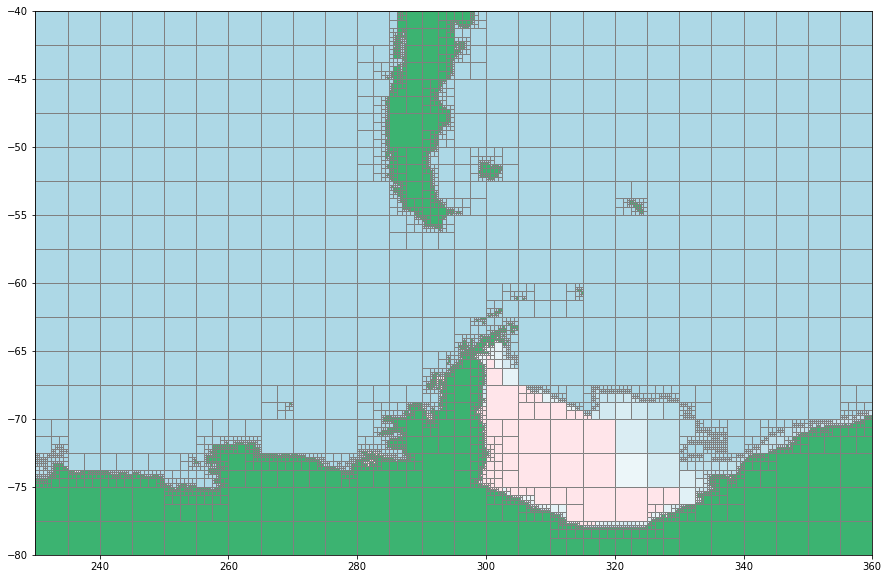

In [3]:
icePoints     = LoadIcePoints('../../Data/bsose_i122_2013to2017_1day_SeaIceArea.nc',OptInfo['Start Time'],OptInfo['End Time'])
currentPoints = LoadCurrentPoints('../../Data/SOSE_surface_velocity_6yearMean_2005-2010.nc')

cellGrid = CellGrid(X[0],X[1],Y[0],Y[1],d[0],d[1])
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)
cellGrid.recursiveSplit(4)
Plot.Mesh(cellGrid)

=== Processing Waypoint = Palmer ===


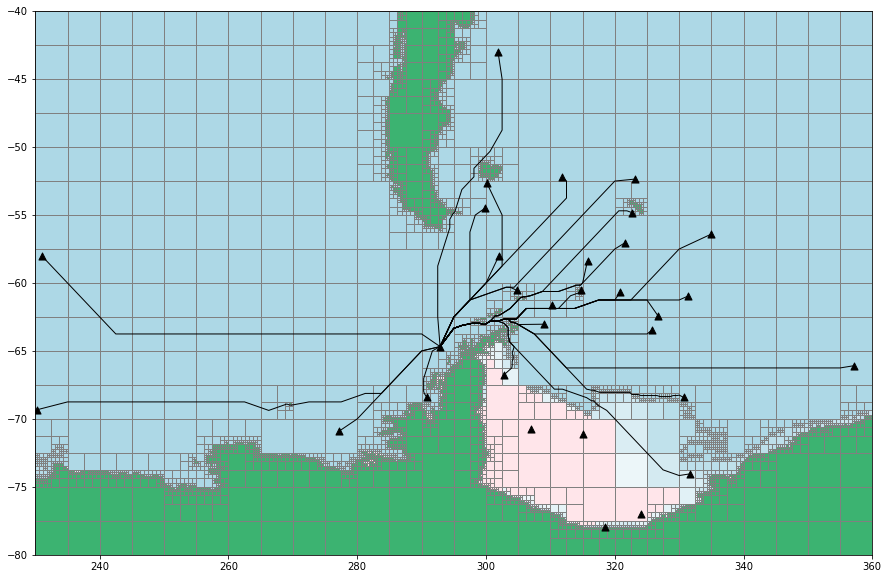

In [4]:
TT = TravelTime(cellGrid,OptInfo)
Paths = TT.Paths(source_waypoints=['Palmer'],verbrose=True)#,end_waypoints=['NorthPeninsula'])
Plot.Paths(cellGrid,Paths,routepoints=False,Waypoints=TT.OptInfo['WayPoints'])

In [5]:
# ==================
def MapWaypoints(json,map):
    for pt in json['features']:
        loc = pt['geometry']['coordinates']
        folium.Marker(
        location=[loc[1], loc[0]],
        name='WayPoints',
        # icon=folium.Icon(color="red",icon="cloud"),
        icon=folium.DivIcon(html=f"""
            <div><svg>
                <rect x="0", y="0" width="10" height="10", fill="red", opacity="1.0" 
            </svg></div>"""),
        popup="<b>{} [{},{}]</b>".format(pt['properties']['name'],loc[0],loc[1])
        ).add_to(map)    
    return map

def MapMesh(DF,map):
    LandDF = DF[DF['Land'] == True]
    IceDF  = DF[DF['Land'] == False]
    ThickIceDF = IceDF[IceDF['Ice Area'] >= 0.8*100]
    ThinIceDF  = IceDF[IceDF['Ice Area'] < 0.8*100]

    # ==== Plotting Ice ==== 
    colormap = linear.Reds_09.scale(min(ThinIceDF['Ice Area']),
                                                max(ThinIceDF['Ice Area']))
    style_function = lambda x: {
        'fillColor': colormap(x['properties']['Ice Area']),
        'color': 'gray',
        'weight': 0.5,
        'fillOpacity': 0.3
    }
    folium.GeoJson(
        ThinIceDF,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['Ice Area', 'Land','Centroid','Depth','Vector'],
            aliases=['Ice Area (%)', 'Land','Centroid [Long,Lat]','Depth(m)','Vector (m/s)'],
            localize=True
        ),
        name='Ice Grid'
    ).add_to(map)
    # colormap.add_to(map)
    # colormap.caption = 'Ice Area'
    # colormap.add_to(map)
    style_function = lambda x: {
        'fillColor': 'white',
        'color': 'gray',
        'weight': 0.5,
        'fillOpacity': 0.5
    }
    folium.GeoJson(
        ThickIceDF,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['Ice Area', 'Land','Centroid','Depth','Vector'],
            aliases=['Ice Area (%)', 'Land','Centroid [Long,Lat]','Depth(m)','Vector (m/s)'],
            localize=True
        ),
        name='No-Go Ice Grid'
    ).add_to(map)

    # ===== Plotting Land =====
    style_function = lambda x: {
        'fillColor': 'green',
        'color': 'gray',
        'weight': 0.5,
        'fillOpacity': 0.3
    }
    folium.GeoJson(
        LandDF,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['Ice Area', 'Land','Centroid','Depth','Vector'],
            aliases=['Ice Area (%)', 'Land','Centroid [Long,Lat]','Depth(m)','Vector (m/s)'],
            localize=True
        ),
        name='Land Grid'
    ).add_to(map)

    return map



In [29]:



from folium.plugins import FloatImage, BoatMarker
from branca.colormap import linear
import folium
import numpy as np
import base64

SDA = SDAPosition('/Users/jsmith/Documents/Research/Researcher_BAS/RoutePlanning/SDADT-Positions')
SDAc = SDA.iloc[np.argmax(SDA['Time'])]

m = folium.Map(location=[SDAc['Lat'],SDAc['Long']-360],zoom_start=4.8,tiles=None)
folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}.png',attr="toner-bcg", name='Basemap').add_to(m)

style = {
    'color': 'black'
}

m = MapMesh(MeshDF(cellGrid),m)
folium.GeoJson(PathsJSON(Paths),name='Paths',style_function=lambda x:style).add_to(m)
m = MapWaypoints(WaypointsJSON(TT.OptInfo['WayPoints']),m)

folium.LayerControl().add_to(m)

folium.plugins.BoatMarker([SDAc['Lat'],SDAc['Long']-360],heading=SDAc['Heading'],name='SDA').add_to(m)


File = "file:///Users/jsmith/Documents/Research/Researcher_BAS/RoutePlanning/OnlinePortal/Logo.png"
FloatImage('File').add_to(m)

m.save('Test.html')

/Users/jsmith/miniconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [30]:
m

In [ ]:
SmoothedPaths = TT.PathSmoothing([Paths[0]],maxiter=50)

In [ ]:
ax = Plot.Paths(cellGrid,SmoothedPaths,routepoints=True,Waypoints=TT.OptInfo['WayPoints'],return_ax=True)
ax.set_xlim([290,310])
ax.set_ylim([-65,-60])

ax.set_xlim([298.5,301])
ax.set_ylim([-63.5,-63])


In [ ]:
Plot.Paths2KML(SmoothedPaths,'RoutePaths_Smoothed.kml')
Plot.Paths2KML(Paths,'RoutePaths_NonSmoothed.kml')
Plot.Mesh2KML(cellGrid,'RoutePaths_Mesh.kml',MaxIce=0.8)
Plot.WayPoints2KML(TT.OptInfo['WayPoints'],'RoutePaths_WayPoints.kml')

In [ ]:
ax = Plot.Paths(cellGrid,SmoothedPaths,routepoints=True,Waypoints=TT.OptInfo['WayPoints'],return_ax=True)
ax.set_ylim([-72,-67])
ax.set_xlim([270,300])

Sp=(287.6112854450627,-67.5);Cp=(285.0,-68.23362159857918);Np=(283.71376404653165,-68.75)
ax.scatter(Sp[0],Sp[1],50,'r',zorder=200)
ax.scatter(Cp[0],Cp[1],50,'r',zorder=200)
ax.scatter(Np[0],Np[1],50,'r',zorder=200)


import numpy as np
from shapely.geometry import Polygon
Cp_cells = TT.Mesh.getCellBox(Cp[0],Cp[1])
Sp_cells = TT.Mesh.getCellBox(Sp[0],Sp[1])
CrossingPoints = []
Bxs = []
for Spc in Sp_cells:
    SPoly = Polygon(Spc.getBounds())
    for Cpc in Cp_cells:
        CPoly = Polygon(Cpc.getBounds())
        if SPoly.intersects(CPoly):
            crp = TT.Mesh.getCrossingPoint(Spc,(Cpc.cx,Cpc.cy))
            if abs(Sp[0]-crp[0]) == 0 or abs(Sp[1]-crp[1]) == 0:
                continue
            print(Spc.cx,Spc.cy,crp[0],crp[1])
            CrossingPoints.append(TT.Mesh.getCrossingPoint(Spc,(Cpc.cx,Cpc.cy)))
            Bxs.append([Spc,Cpc])




for idx,c in enumerate(CrossingPoints):
    ax.scatter(c[0],c[1],50,'b',zorder=200)



In [ ]:
for c in CrossingPoints:
    print(c)